

# Predicción casos de Covid-19

## Importación de librerías

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import missingno as msno
import scipy.stats as stats
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
%matplotlib inline
import seaborn as sns

## Dataset

In [80]:
### Se carga los datos
path = '/content/drive/MyDrive/Proyecto-IA-Final/owid-covid-data.xlsx'
data = pd.read_excel(path)
## Se selecciona los datos de Ecuador
data=data[(data["location"] == 'Ecuador')]
data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
40391,ECU,South America,Ecuador,2020-03-01,6.0,6.0,NaN,NaN,NaN,NaN,0.335,0.335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.56,17888474.0,66.939,28.1,7.104,4.458,10581.936,3.6,140.448,5.55,2.0,12.3,80.635,1.5,77.01,0.759,-254.9,-1.89,2.36,-14.249399
40392,ECU,South America,Ecuador,2020-03-02,6.0,0.0,NaN,NaN,NaN,NaN,0.335,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,17888474.0,66.939,28.1,7.104,4.458,10581.936,3.6,140.448,5.55,2.0,12.3,80.635,1.5,77.01,0.759,NaN,NaN,NaN,NaN
40393,ECU,South America,Ecuador,2020-03-03,7.0,1.0,NaN,NaN,NaN,NaN,0.391,0.056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,17888474.0,66.939,28.1,7.104,4.458,10581.936,3.6,140.448,5.55,2.0,12.3,80.635,1.5,77.01,0.759,NaN,NaN,NaN,NaN
40394,ECU,South America,Ecuador,2020-03-04,10.0,3.0,NaN,NaN,NaN,NaN,0.559,0.168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,17888474.0,66.939,28.1,7.104,4.458,10581.936,3.6,140.448,5.55,2.0,12.3,80.635,1.5,77.01,0.759,NaN,NaN,NaN,NaN
40395,ECU,South America,Ecuador,2020-03-05,13.0,3.0,NaN,NaN,NaN,NaN,0.727,0.168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,17888474.0,66.939,28.1,7.104,4.458,10581.936,3.6,140.448,5.55,2.0,12.3,80.635,1.5,77.01,0.759,NaN,NaN,NaN,NaN


## Exploración de los datos

In [81]:
### Se obtiene información de los datos cargados
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 684 entries, 40391 to 41074
Data columns (total 67 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   iso_code                                    684 non-null    object 
 1   continent                                   684 non-null    object 
 2   location                                    684 non-null    object 
 3   date                                        684 non-null    object 
 4   total_cases                                 684 non-null    float64
 5   new_cases                                   684 non-null    float64
 6   new_cases_smoothed                          679 non-null    float64
 7   total_deaths                                671 non-null    float64
 8   new_deaths                                  669 non-null    float64
 9   new_deaths_smoothed                         669 non-null    float64
 10  total_ca

### 1. Eliminación de columnas vacías

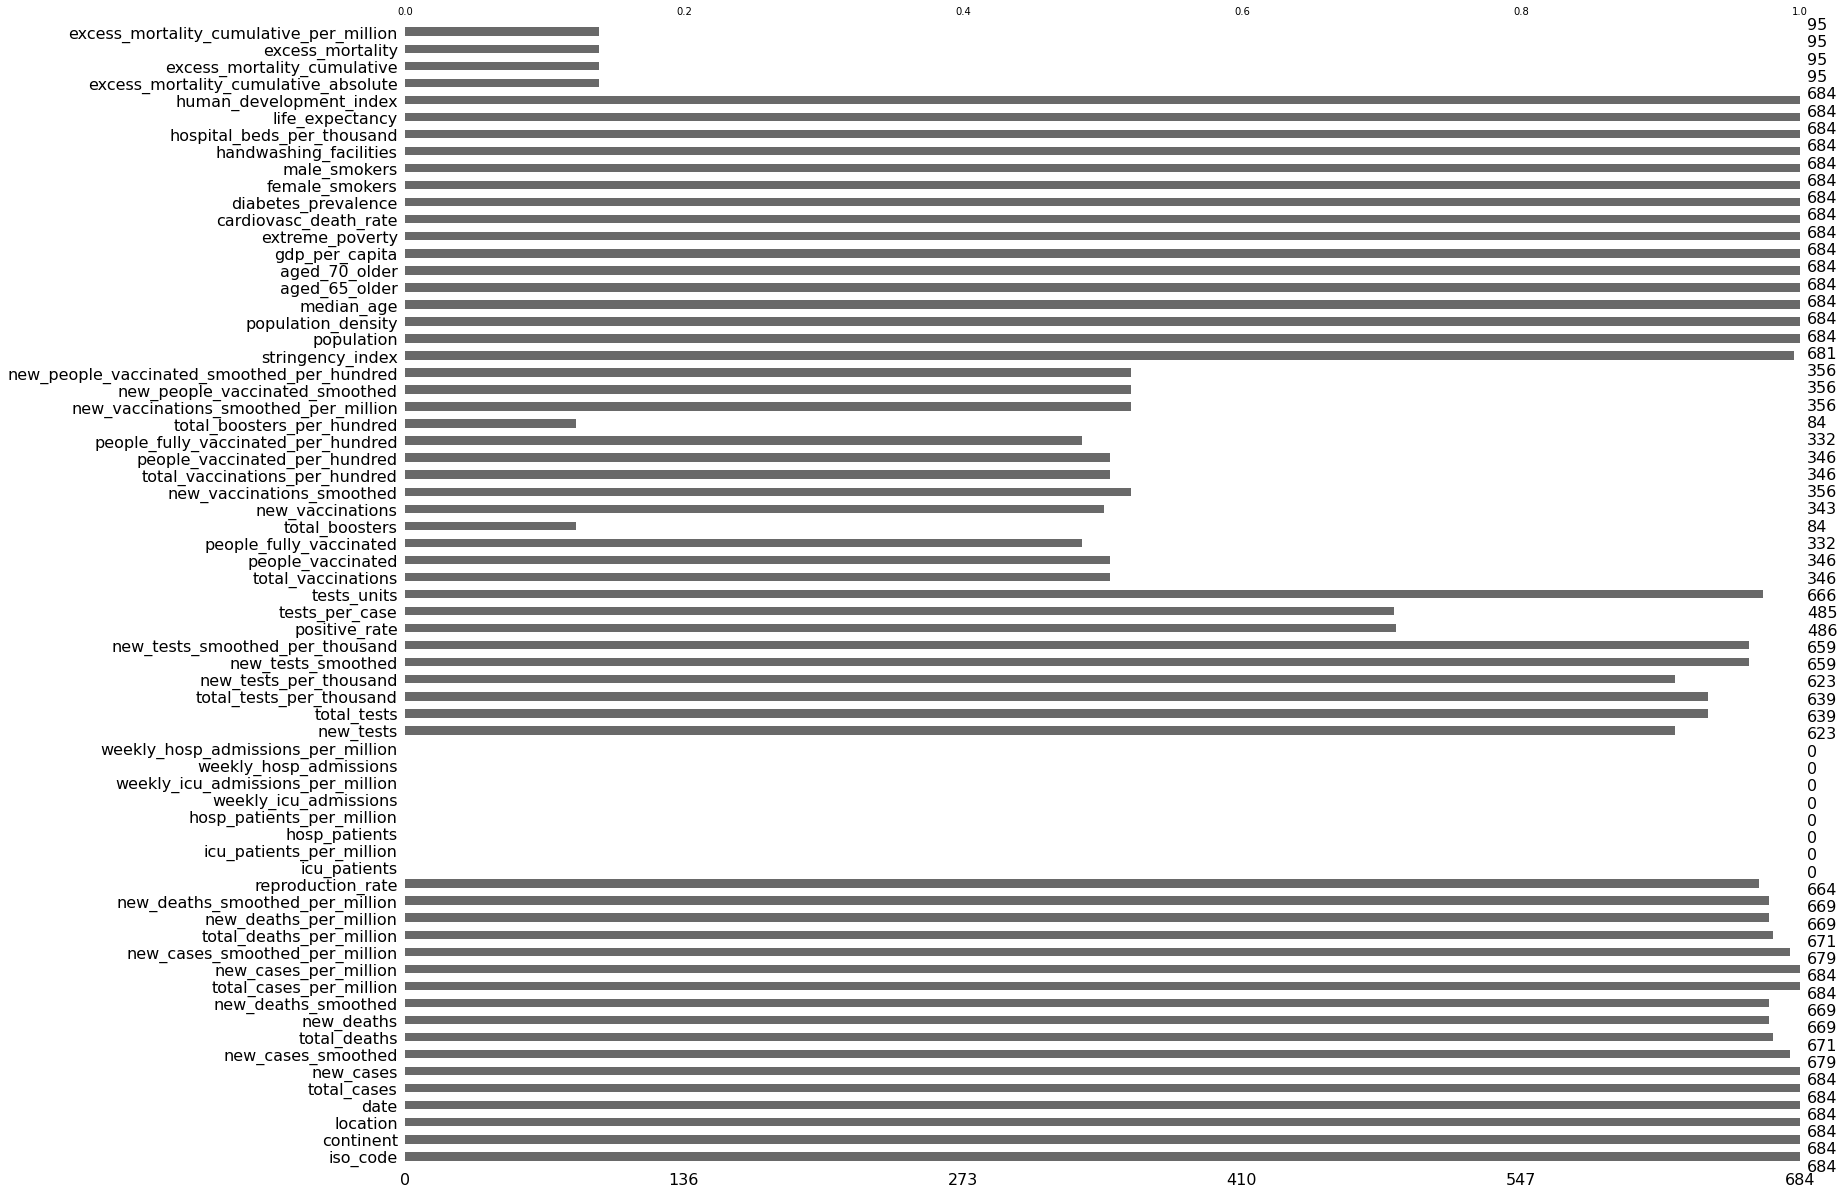

In [82]:
### Se muestra mediante un gráfico de barras para ver de forma más intuitiva la proporción y la cantidad de cada variable que falta.
msno.bar(data)

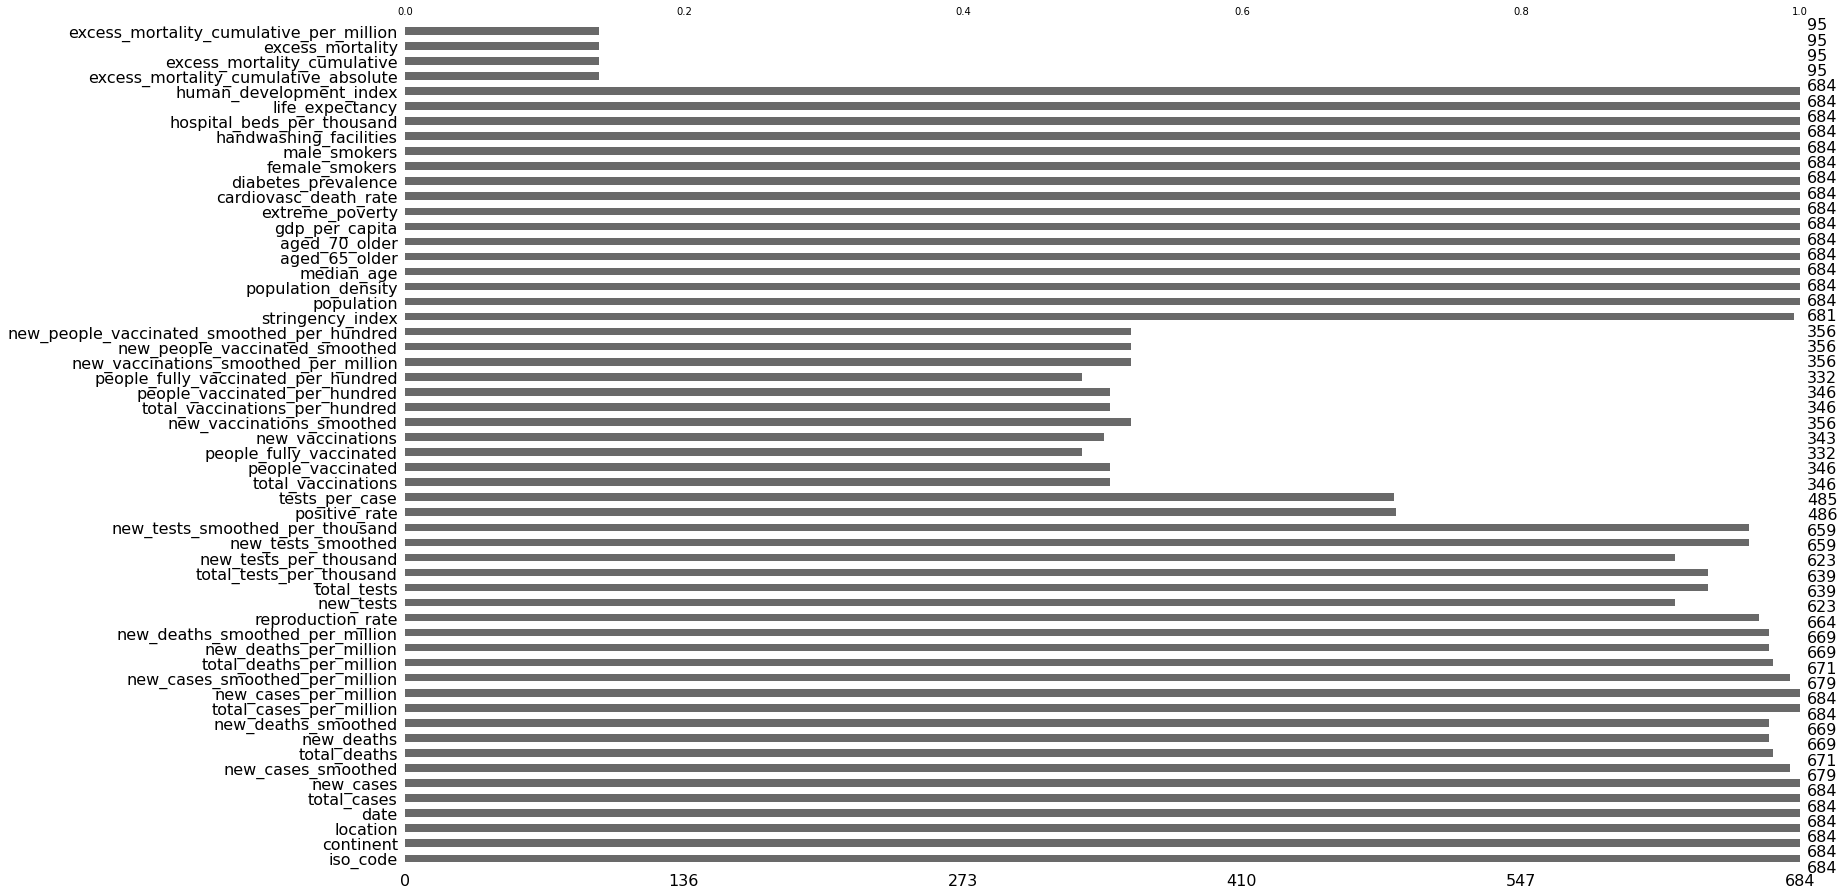

In [83]:
### Se observa que existen columnas vacías, las cuales se proceden a eliminar.
dataclean = data.drop(['icu_patients', 'tests_units', 'total_boosters', 'icu_patients_per_million', 'total_boosters_per_hundred', 'hosp_patients', 'hosp_patients_per_million', 'weekly_icu_admissions', 'weekly_icu_admissions_per_million', 'weekly_hosp_admissions', 'weekly_hosp_admissions_per_million'], axis=1)

### Se muestra la data sin columnas vacías
msno.bar(dataclean)

In [84]:
#Tomar columnas numéricas
arreglo = list(dataclean.columns)
columnas_numericas = dataclean[arreglo[4:len(arreglo)]]
columnas_numericas.round(0)

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
40391,6.0,6.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,17888474.0,67.0,28.0,7.0,4.0,10582.0,4.0,140.0,6.0,2.0,12.0,81.0,2.0,77.0,1.0,-255.0,-2.0,2.0,-14.0
40392,6.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,17888474.0,67.0,28.0,7.0,4.0,10582.0,4.0,140.0,6.0,2.0,12.0,81.0,2.0,77.0,1.0,NaN,NaN,NaN,NaN
40393,7.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,17888474.0,67.0,28.0,7.0,4.0,10582.0,4.0,140.0,6.0,2.0,12.0,81.0,2.0,77.0,1.0,NaN,NaN,NaN,NaN
40394,10.0,3.0,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,17888474.0,67.0,28.0,7.0,4.0,10582.0,4.0,140.0,6.0,2.0,12.0,81.0,2.0,77.0,1.0,NaN,NaN,NaN,NaN
40395,13.0,3.0,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,17888474.0,67.0,28.0,7.0,4.0,10582.0,4.0,140.0,6.0,2.0,12.0,81.0,2.0,77.0,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41070,559950.0,0.0,1505.0,33699.0,0.0,3.0,31302.0,0.0,84.0,1884.0,0.0,0.0,1.0,6413.0,2082236.0,116.0,0.0,4774.0,0.0,0.0,3.0,28210822.0,14343201.0,12867653.0,38070.0,90954.0,158.0,80.0,72.0,5085.0,16732.0,0.0,58.0,17888474.0,67.0,28.0,7.0,4.0,10582.0,4.0,140.0,6.0,2.0,12.0,81.0,2.0,77.0,1.0,NaN,NaN,NaN,NaN
41071,559950.0,0.0,964.0,33699.0,0.0,2.0,31302.0,0.0,54.0,1884.0,0.0,0.0,1.0,4352.0,2086588.0,117.0,0.0,4965.0,0.0,0.0,5.0,28348820.0,14371961.0,12907842.0,137998.0,98287.0,158.0,80.0,72.0,5494.0,18430.0,0.0,58.0,17888474.0,67.0,28.0,7.0,4.0,10582.0,4.0,140.0,6.0,2.0,12.0,81.0,2.0,77.0,1.0,NaN,NaN,NaN,NaN
41072,559950.0,0.0,964.0,33699.0,0.0,2.0,31302.0,0.0,54.0,1884.0,0.0,0.0,1.0,14900.0,2101488.0,117.0,1.0,6591.0,0.0,0.0,7.0,28491355.0,14402651.0,12951049.0,142535.0,102934.0,159.0,81.0,72.0,5754.0,19932.0,0.0,NaN,17888474.0,67.0,28.0,7.0,4.0,10582.0,4.0,140.0,6.0,2.0,12.0,81.0,2.0,77.0,1.0,NaN,NaN,NaN,NaN
41073,559950.0,0.0,964.0,33699.0,0.0,2.0,31302.0,0.0,54.0,1884.0,0.0,0.0,NaN,16587.0,2118075.0,118.0,1.0,7929.0,0.0,0.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17888474.0,67.0,28.0,7.0,4.0,10582.0,4.0,140.0,6.0,2.0,12.0,81.0,2.0,77.0,1.0,NaN,NaN,NaN,NaN


##2. Reemplazar valores faltantes NaN por la media de cada variable

In [85]:
### Obtener la media de las columnas numéricas
columnas_numericas.mean()

total_cases                                   2.769674e+05
new_cases                                     8.186404e+02
new_cases_smoothed                            8.246598e+02
total_deaths                                  1.707165e+04
new_deaths                                    3.148132e+01
new_deaths_smoothed                           3.141854e+01
total_cases_per_million                       1.548301e+04
new_cases_per_million                         4.576357e+01
new_cases_smoothed_per_million                4.610006e+01
total_deaths_per_million                      9.543380e+02
new_deaths_per_million                        1.759868e+00
new_deaths_smoothed_per_million               1.756345e+00
reproduction_rate                             1.030889e+00
new_tests                                     3.256098e+03
total_tests                                   9.271506e+05
total_tests_per_thousand                      5.182951e+01
new_tests_per_thousand                        1.820321e-

In [86]:
### Reemplazar los valores NaN con la media de cada una de las caracteristicas numéricas
columnas_numericas = columnas_numericas.fillna(columnas_numericas.mean())
columnas_numericas

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
40391,6.0,6.0,824.659789,17071.651267,31.481315,31.418535,0.335,0.335,46.100065,954.338034,1.759868,1.756345,1.030889,3256.097913,9.271506e+05,51.829507,0.182032,3163.569044,0.176862,0.234462,6.374639,1.121434e+07,6.533728e+06,4.894158e+06,81108.25656,79168.132022,62.690347,36.524509,27.359548,4425.643258,40295.176966,0.225244,5.560000,17888474.0,66.939,28.1,7.104,4.458,10581.936,3.6,140.448,5.55,2.0,12.3,80.635,1.5,77.01,0.759,-254.900000,-1.890000,2.360000,-14.249399
40392,6.0,0.0,824.659789,17071.651267,31.481315,31.418535,0.335,0.000,46.100065,954.338034,1.759868,1.756345,1.030889,3256.097913,9.271506e+05,51.829507,0.182032,3163.569044,0.176862,0.234462,6.374639,1.121434e+07,6.533728e+06,4.894158e+06,81108.25656,79168.132022,62.690347,36.524509,27.359548,4425.643258,40295.176966,0.225244,8.330000,17888474.0,66.939,28.1,7.104,4.458,10581.936,3.6,140.448,5.55,2.0,12.3,80.635,1.5,77.01,0.759,43504.585263,52.922632,48.504316,2431.989742
40393,7.0,1.0,824.659789,17071.651267,31.481315,31.418535,0.391,0.056,46.100065,954.338034,1.759868,1.756345,1.030889,3256.097913,9.271506e+05,51.829507,0.182032,3163.569044,0.176862,0.234462,6.374639,1.121434e+07,6.533728e+06,4.894158e+06,81108.25656,79168.132022,62.690347,36.524509,27.359548,4425.643258,40295.176966,0.225244,8.330000,17888474.0,66.939,28.1,7.104,4.458,10581.936,3.6,140.448,5.55,2.0,12.3,80.635,1.5,77.01,0.759,43504.585263,52.922632,48.504316,2431.989742
40394,10.0,3.0,824.659789,17071.651267,31.481315,31.418535,0.559,0.168,46.100065,954.338034,1.759868,1.756345,1.030889,3256.097913,9.271506e+05,51.829507,0.182032,3163.569044,0.176862,0.234462,6.374639,1.121434e+07,6.533728e+06,4.894158e+06,81108.25656,79168.132022,62.690347,36.524509,27.359548,4425.643258,40295.176966,0.225244,8.330000,17888474.0,66.939,28.1,7.104,4.458,10581.936,3.6,140.448,5.55,2.0,12.3,80.635,1.5,77.01,0.759,43504.585263,52.922632,48.504316,2431.989742
40395,13.0,3.0,824.659789,17071.651267,31.481315,31.418535,0.727,0.168,46.100065,954.338034,1.759868,1.756345,1.030889,3256.097913,9.271506e+05,51.829507,0.182032,3163.569044,0.176862,0.234462,6.374639,1.121434e+07,6.533728e+06,4.894158e+06,81108.25656,79168.132022,62.690347,36.524509,27.359548,4425.643258,40295.176966,0.225244,8.330000,17888474.0,66.939,28.1,7.104,4.458,10581.936,3.6,140.448,5.55,2.0,12.3,80.635,1.5,77.01,0.759,43504.585263,52.922632,48.504316,2431.989742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41070,559950.0,0.0,1504.571000,33699.000000,0.000000,2.571000,31302.279,0.000,84.108000,1883.839000,0.000000,0.144000,1.130000,6413.000000,2.082236e+06,116.401000,0.358000,4774.000000,0.267000,0.315200,3.200000,2.821082e+07,1.434320e+07,1.286765e+07,38070.00000,90954.000000,157.70

In [87]:
## Visualizamos nuevamente la data ahora llamada columnas_numericas
columnas_numericas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 684 entries, 40391 to 41074
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   total_cases                                 684 non-null    float64
 1   new_cases                                   684 non-null    float64
 2   new_cases_smoothed                          684 non-null    float64
 3   total_deaths                                684 non-null    float64
 4   new_deaths                                  684 non-null    float64
 5   new_deaths_smoothed                         684 non-null    float64
 6   total_cases_per_million                     684 non-null    float64
 7   new_cases_per_million                       684 non-null    float64
 8   new_cases_smoothed_per_million              684 non-null    float64
 9   total_deaths_per_million                    684 non-null    float64
 10  new_deat

##3. Obtener la matriz de correlación entre variables

In [88]:
### Verificar la relación que existe entre la variable objetivo "nuevo casos de covid" y las demás variables
matriz_correlacion=columnas_numericas.corr('pearson').round(4)
matriz_correlacion

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
total_cases,1.0000,0.0175,0.0424,0.9524,-0.1214,-0.2258,1.0000,0.0175,0.0424,0.9524,-0.1214,-0.2258,-0.6243,0.2636,0.9373,0.9373,0.2634,0.4080,0.4078,-0.2525,0.1606,0.3146,0.3249,0.2714,0.1585,0.1758,0.3146,0.3249,0.2714,0.1758,0.0850,0.0850,-0.3767,NaN,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,NaN,0.0,-0.0,NaN,0.0,0.0,0.3555,-0.0052,-0.1427,0.3555
new_cases,0.0175,1.0000,0.5136,-0.0663,0.3667,0.2043,0.0175,1.0000,0.5136,-0.0663,0.3667,0.2043,0.0236,0.4919,0.0130,0.0130,0.4920,0.3234,0.3233,0.3937,-0.1854,-0.2963,-0.3064,-0.2791,-0.0965,-0.1378,-0.2963,-0.3064,-0.2791,-0.1378,-0.0308,-0.0308,0.0389,NaN,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,NaN,-0.0,-0.0,NaN,-0.0,0.0,0.0284,0.0523,0.0266,0.0284
new_cases_smoothed,0.0424,0.5136,1.0000,-0.1080,0.1719,0.3618,0.0424,0.5136,1.0000,-0.1080,0.1719,0.3618,-0.0019,0.4058,0.0113,0.0113,0.4059,0.6504,0.6506,0.7433,-0.3477,-0.5741,-0.5917,-0.5420,-0.2195,-0.2503,-0.5741,-0.5917,-0.5420,-0.2503,-0.0430,-0.0430,0.0030,NaN,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,NaN,-0.0,-0.0,NaN,-0.0,-0.0,0.0402,0.1075,0.0798,0.0402
total_deaths,0.9524,-0.0663,-0.1080,1.0000,-0.1540,-0.2928,0.9524,-0.0663,-0.1080,1.0000,-0.1540,-0.2928,-0.6610,0.2298,0.9307,0.9307,0.2296,0.3473,0.3470,-0.3836,0.2117,0.4683,0.4800,0.4262,0.1866,0.2204,0.4683,0.4800,0.4262,0.2204,0.0652,0.0652,-0.5344,NaN,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,NaN,0.0,-0.0,NaN,-0.0,-0.0,0.3250,-0.0522,-0.1834,0.3250
new_deaths,-0.1214,0.3667,0.1719,-0.1540,1.0000,0.5002,-0.1214,0.3667,0.1719,-0.1540,1.0000,0.5002,0.0043,0.1465,-0.1129,-0.1129,0.1465,0.0149,0.0148,0.2322,-0.1140,-0.2220,-0.2095,-0.2309,0.0102,-0.0310,-0.2220,-0.2095,-0.2309,-0.0310,0.0308,0.0309,0.1170,NaN,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,NaN,-0.0,-0.0,NaN,0.0,0.0,-0.0537,0.0634,0.0381,-0.0537
new_deaths_smoothed,-0.2258,0.2043,0.3618,-0.2928,0.5002,1.0000,-0.2258,0.2043,0.3618,-0.2928,0.5002,1.0000,-0.0199,0.0493,-0.2203,-0.2203,0.0493,0.0300,0.0301,0.4782,-0.2233,-0.4311,-0.4059,-0.4500,-0.0593,-0.0588,-0.4311,-0.4059,-0.4500,-0.0588,0.0552,0.0552,0.2009,NaN,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,NaN,0.0,-0.0,NaN,0.0,0.0,-0.0389,0.1324,0.0730,-0.0389
total_cases_per_million,1.0000,0.0175,0.0424,0.9524,-0.1214,-0.2258,1.0000,0.0175,0.0424,0.9524,-0.1214,-0.2258,-0.6243,0.2636,0.9373,0.9373,0.2634,0.4080,0.4078,-0.2525,0.1606,0.3146,0.3249,0.2714,0.1585,0.1758,0.3146,0.3249,0.2714,0.1758,0.0850,0.0850,-0.3767,NaN,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,NaN,-0.0,-0.0,NaN,-0.0,-0.0,0.3555,-0.0052,-0.1427,0.3555
new_cases_per_million,0.0175,1.0000,0.5136,-0.0663,0.3667,0.2043,0.0175,1.0000,0.5136,-0.0663,0.3667,0.2043,0.0236,0.4919,0.0130,0.0130,0.4920,0.3234,0.3233,0.3937,-0.1854,-0.2963,-0.3064,-0.2791,-0.0965,-0.1378,-0.2963,-0.3064,-0.2791,-0.1378,-0.0308,-0.0308,0.0389,NaN,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0284,0.0523,0.0266,0.0284
new_cases_smoothed_per_million,0

In [90]:
### Visualización de columnas NaN, al parecer estas columnas no cambian de valor, por tanto no existe correlación
columnas_numericas['population']

40391    17888474.0
40392    17888474.0
40393    17888474.0
40394    17888474.0
40395    17888474.0
            ...    
41070    17888474.0
41071    17888474.0
41072    17888474.0
41073    17888474.0
41074    17888474.0
Name: population, Length: 684, dtype: float64

In [91]:
columnas_numericas['female_smokers']

40391    2.0
40392    2.0
40393    2.0
40394    2.0
40395    2.0
        ... 
41070    2.0
41071    2.0
41072    2.0
41073    2.0
41074    2.0
Name: female_smokers, Length: 684, dtype: float64

In [92]:
columnas_numericas['hospital_beds_per_thousand']

40391    1.5
40392    1.5
40393    1.5
40394    1.5
40395    1.5
        ... 
41070    1.5
41071    1.5
41072    1.5
41073    1.5
41074    1.5
Name: hospital_beds_per_thousand, Length: 684, dtype: float64

In [93]:
columnas_numericas['aged_65_older']

40391    7.104
40392    7.104
40393    7.104
40394    7.104
40395    7.104
         ...  
41070    7.104
41071    7.104
41072    7.104
41073    7.104
41074    7.104
Name: aged_65_older, Length: 684, dtype: float64

In [94]:
d1=columnas_numericas.corr('pearson')['new_cases'].sort_values(ascending=False).round(3)
d1

new_cases                                     1.000
new_cases_per_million                         1.000
new_cases_smoothed                            0.514
new_cases_smoothed_per_million                0.514
new_tests_per_thousand                        0.492
new_tests                                     0.492
positive_rate                                 0.394
new_deaths                                    0.367
new_deaths_per_million                        0.367
new_tests_smoothed                            0.323
new_tests_smoothed_per_thousand               0.323
new_deaths_smoothed_per_million               0.204
new_deaths_smoothed                           0.204
excess_mortality_cumulative                   0.052
stringency_index                              0.039
excess_mortality_cumulative_per_million       0.028
excess_mortality_cumulative_absolute          0.028
excess_mortality                              0.027
reproduction_rate                             0.024
total_cases_

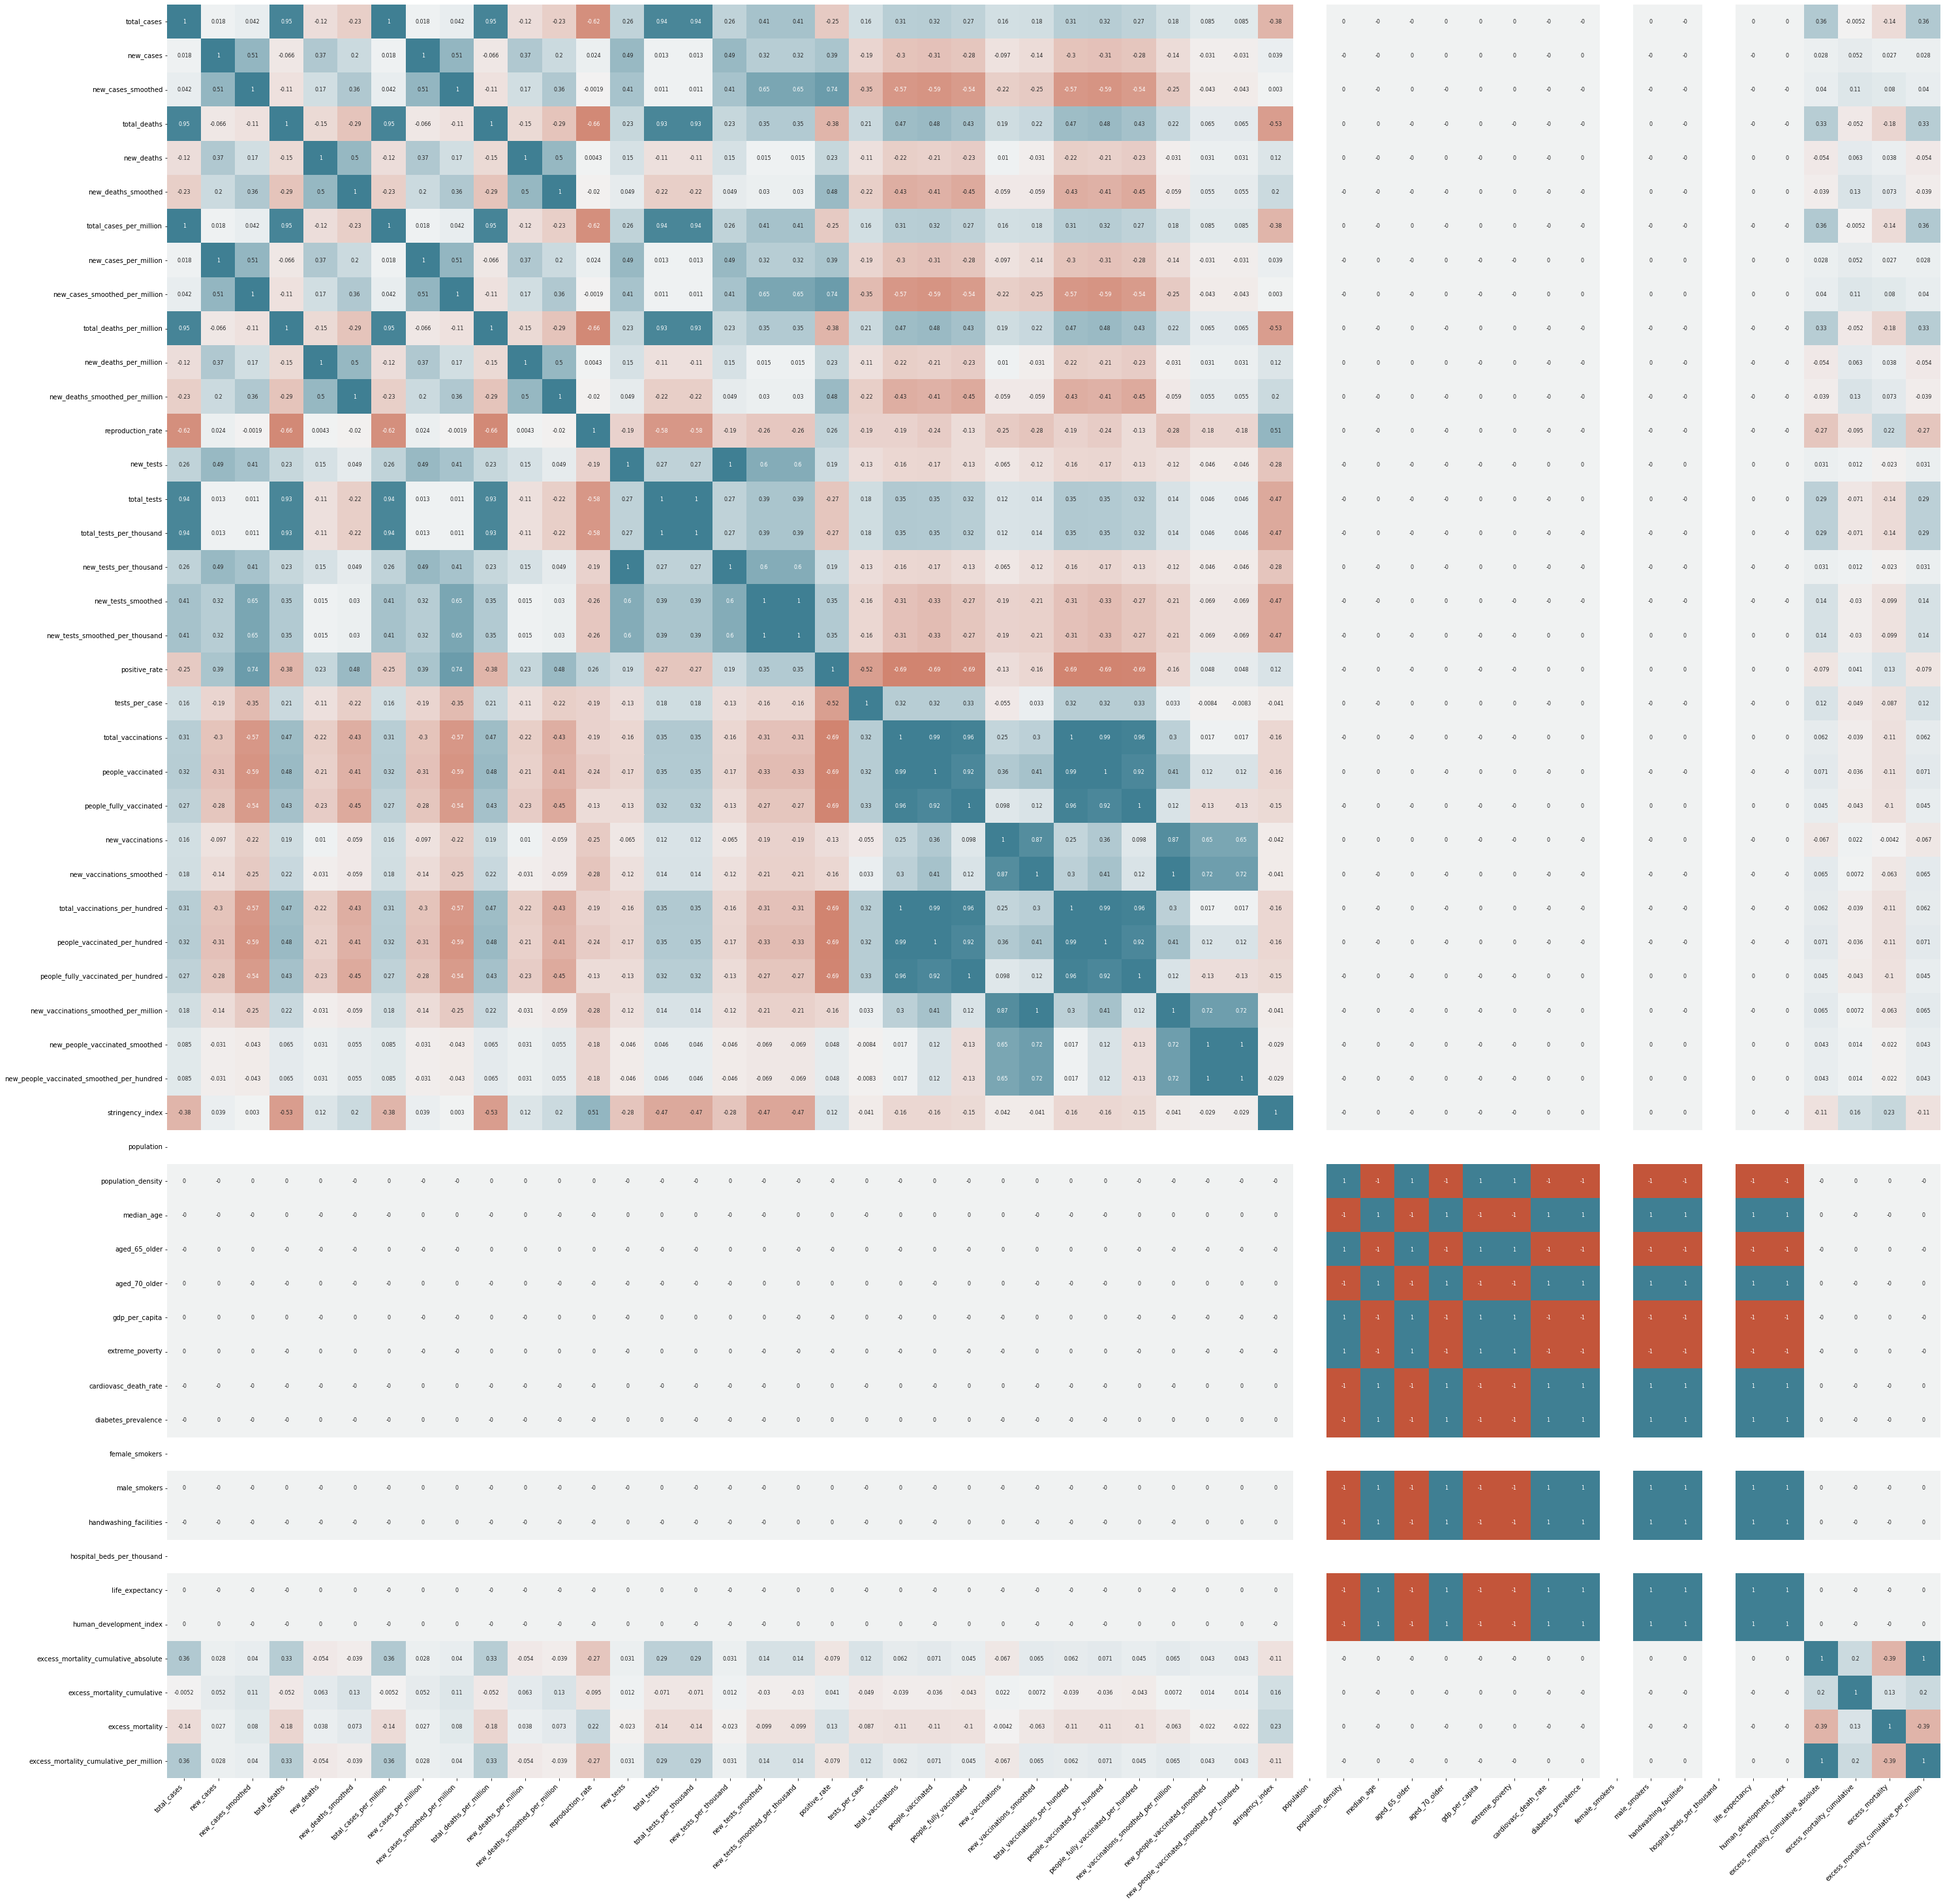

In [95]:
# Heatmap matriz de correlaciones
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(50, 50))

sns.heatmap(
    matriz_correlacion,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10) 

## Reducción del número de características

In [96]:
df_selected = columnas_numericas[['new_cases_smoothed','new_deaths_smoothed','new_tests_smoothed','positive_rate','people_fully_vaccinated', 'people_vaccinated']]
df_selected

,new_cases_smoothed,new_deaths_smoothed,new_tests_smoothed,positive_rate,people_fully_vaccinated,people_vaccinated
40391,824.659789,31.418535,3163.569044,0.234462,4.894158e+06,6.533728e+06
40392,824.659789,31.418535,3163.569044,0.234462,4.894158e+06,6.533728e+06
40393,824.659789,31.418535,3163.569044,0.234462,4.894158e+06,6.533728e+06
40394,824.659789,31.418535,3163.569044,0.234462,4.894158e+06,6.533728e+06
40395,824.659789,31.418535,3163.569044,0.234462,4.894158e+06,6.533728e+06
...,...,...,...,...,...,...
41070,1504.571000,2.571000,4774.000000,0.315200,1.286765e+07,1.434320e+07
41071,964.143000,1.857000,4965.000000,0.194200,1.290784e+07,1.437196e+07
41072,964.143000,1.857000,6591.000000,0.146300,1.295105e+07,1.440265e+07
41073,964.143000,1.857000,7929.000000,0.121600,4.894158e+06,6.533728e+06


##5. Selección manual de las características predictoras y la etiqueta
Las variables que se seleccionaron son:
1. new_cases_smoothed (etiqueta)
2. new_deaths_smoothed
3. new_tests_smoothed
4. positive_rate
6. people_fully_vaccinated
6. people_vaccinated

In [97]:
## Matriz de correlación
matriz_correlacion_selected_var=df_selected.corr('pearson').round(4)
matriz_correlacion_selected_var

,new_cases_smoothed,new_deaths_smoothed,new_tests_smoothed,positive_rate,people_fully_vaccinated,people_vaccinated
new_cases_smoothed,1.0000,0.3618,0.6504,0.7433,-0.5420,-0.5917
new_deaths_smoothed,0.3618,1.0000,0.0300,0.4782,-0.4500,-0.4059
new_tests_smoothed,0.6504,0.0300,1.0000,0.3457,-0.2692,-0.3342
positive_rate,0.7433,0.4782,0.3457,1.0000,-0.6860,-0.6908
people_fully_vaccinated,-0.5420,-0.4500,-0.2692,-0.6860,1.0000,0.9219
people_vaccinated,-0.5917,-0.4059,-0.3342,-0.6908,0.9219,1.0000


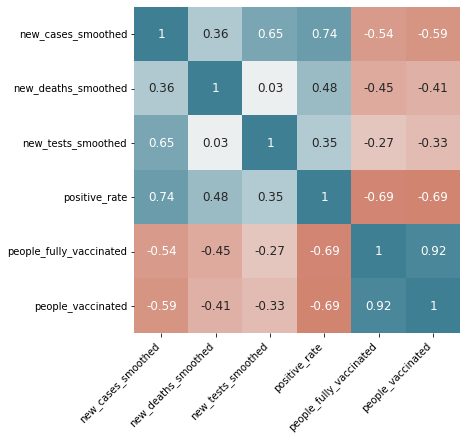

In [98]:
# Heatmap matriz de correlaciones
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.heatmap(
    matriz_correlacion_selected_var,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 12},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10) 

##6. Verificación y eliminación de ouliers

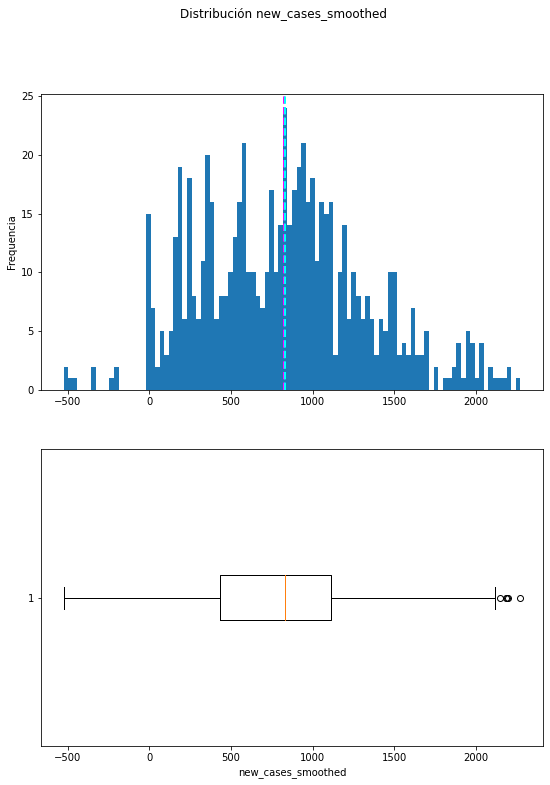

In [99]:
# Get the label column
label = df_selected['new_cases_smoothed']

# Create a figure for 2 subplots (2 rows, 1 column)
fig, ax = plt.subplots(2, 1, figsize = (9,12))

# Plot the histogram   
ax[0].hist(label, bins=100)
ax[0].set_ylabel('Frequencia')

# Add lines for the mean, median, and mode
ax[0].axvline(label.mean(), color='magenta', linestyle='dashed', linewidth=2)
ax[0].axvline(label.median(), color='cyan', linestyle='dashed', linewidth=2)

# Plot the boxplot   
ax[1].boxplot(label, vert=False)
ax[1].set_xlabel('new_cases_smoothed')

# Add a title to the Figure
fig.suptitle('Distribución new_cases_smoothed')

# Show the figure
fig.show()

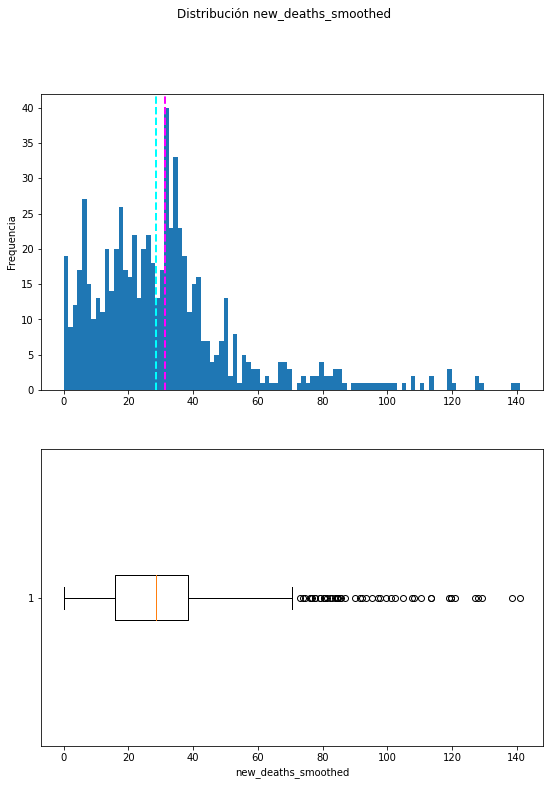

In [100]:
# Get the label column
label = df_selected['new_deaths_smoothed']

# Create a figure for 2 subplots (2 rows, 1 column)
fig, ax = plt.subplots(2, 1, figsize = (9,12))

# Plot the histogram   
ax[0].hist(label, bins=100)
ax[0].set_ylabel('Frequencia')

# Add lines for the mean, median, and mode
ax[0].axvline(label.mean(), color='magenta', linestyle='dashed', linewidth=2)
ax[0].axvline(label.median(), color='cyan', linestyle='dashed', linewidth=2)

# Plot the boxplot   
ax[1].boxplot(label, vert=False)
ax[1].set_xlabel('new_deaths_smoothed')

# Add a title to the Figure
fig.suptitle('Distribución new_deaths_smoothed')

# Show the figure
fig.show()

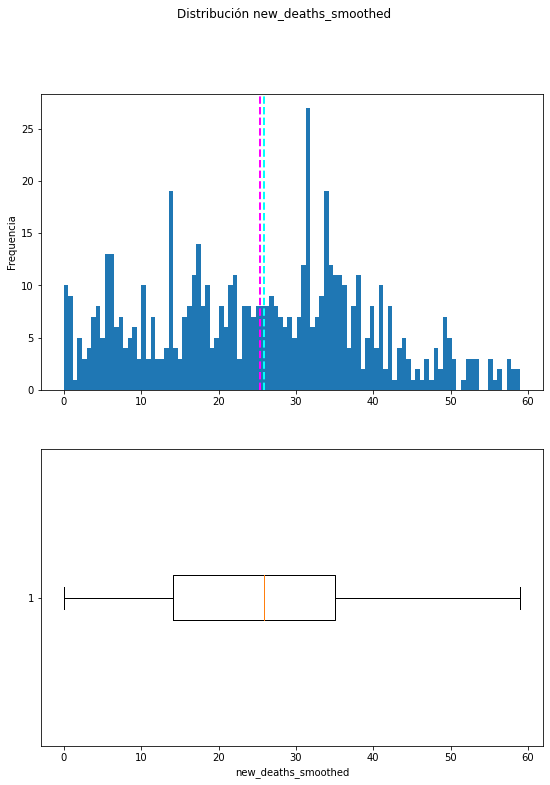

In [101]:
df_selected=df_selected[df_selected['new_deaths_smoothed'] < 60]
# Get the label column
label = df_selected['new_deaths_smoothed']

# Create a figure for 2 subplots (2 rows, 1 column)
fig, ax = plt.subplots(2, 1, figsize = (9,12))

# Plot the histogram   
ax[0].hist(label, bins=100)
ax[0].set_ylabel('Frequencia')

# Add lines for the mean, median, and mode
ax[0].axvline(label.mean(), color='magenta', linestyle='dashed', linewidth=2)
ax[0].axvline(label.median(), color='cyan', linestyle='dashed', linewidth=2)

# Plot the boxplot   
ax[1].boxplot(label, vert=False)
ax[1].set_xlabel('new_deaths_smoothed')

# Add a title to the Figure
fig.suptitle('Distribución new_deaths_smoothed')

# Show the figure
fig.show()


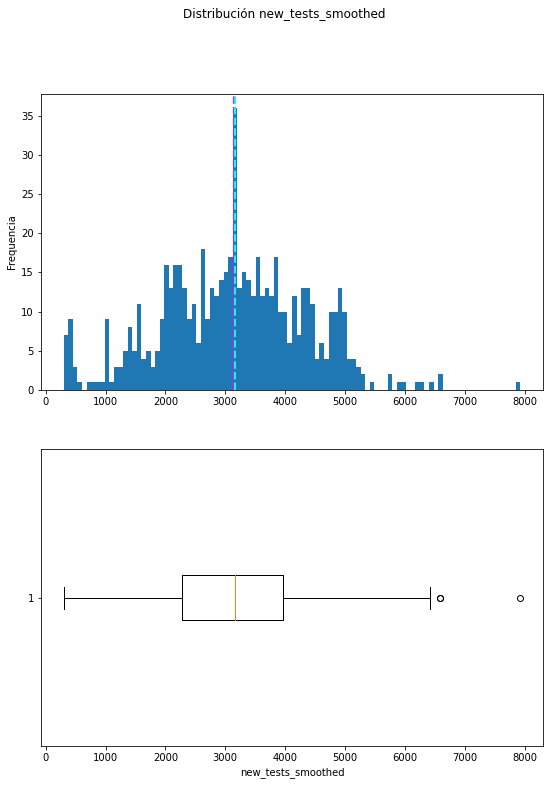

In [102]:
# Get the label column
label = df_selected['new_tests_smoothed']

# Create a figure for 2 subplots (2 rows, 1 column)
fig, ax = plt.subplots(2, 1, figsize = (9,12))

# Plot the histogram   
ax[0].hist(label, bins=100)
ax[0].set_ylabel('Frequencia')

# Add lines for the mean, median, and mode
ax[0].axvline(label.mean(), color='magenta', linestyle='dashed', linewidth=2)
ax[0].axvline(label.median(), color='cyan', linestyle='dashed', linewidth=2)

# Plot the boxplot   
ax[1].boxplot(label, vert=False)
ax[1].set_xlabel('new_tests_smoothed')

# Add a title to the Figure
fig.suptitle('Distribución new_tests_smoothed')

# Show the figure
fig.show()

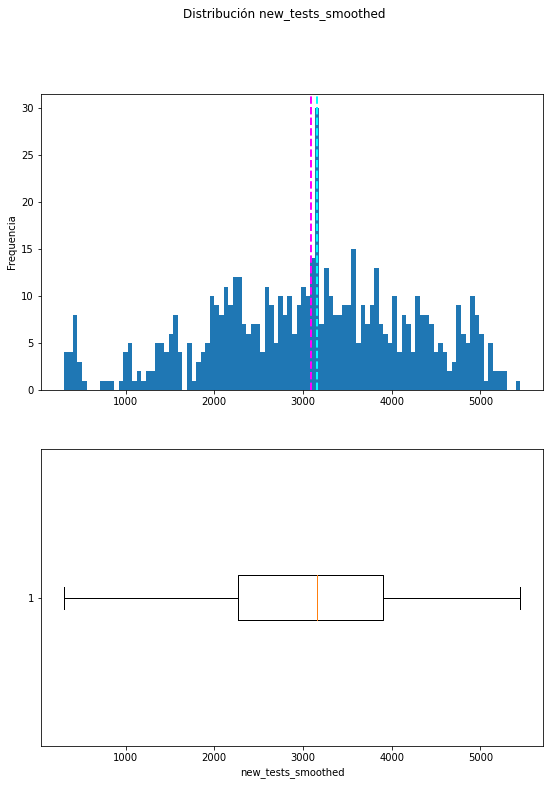

In [103]:
df_selected = df_selected[df_selected['new_tests_smoothed'] < 5500]
# Get the label column
label = df_selected['new_tests_smoothed']

# Create a figure for 2 subplots (2 rows, 1 column)
fig, ax = plt.subplots(2, 1, figsize = (9,12))

# Plot the histogram   
ax[0].hist(label, bins=100)
ax[0].set_ylabel('Frequencia')

# Add lines for the mean, median, and mode
ax[0].axvline(label.mean(), color='magenta', linestyle='dashed', linewidth=2)
ax[0].axvline(label.median(), color='cyan', linestyle='dashed', linewidth=2)

# Plot the boxplot   
ax[1].boxplot(label, vert=False)
ax[1].set_xlabel('new_tests_smoothed')

# Add a title to the Figure
fig.suptitle('Distribución new_tests_smoothed')

# Show the figure
fig.show()

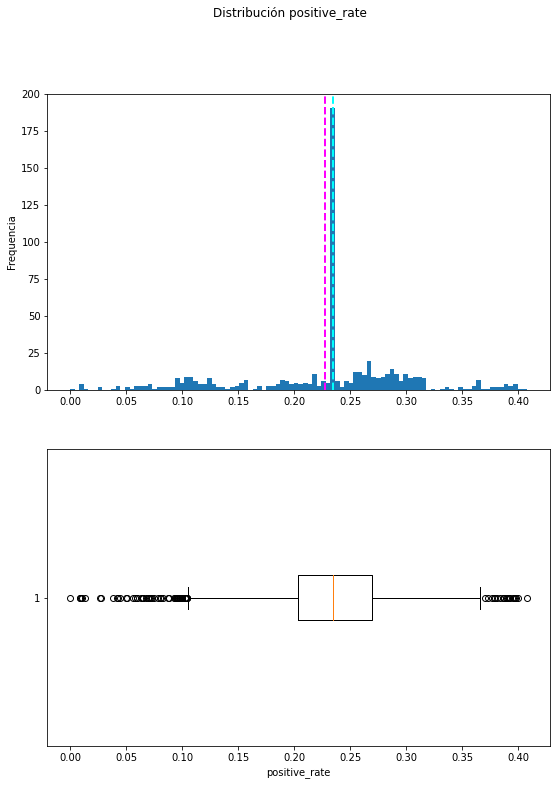

In [104]:
# Get a label column
label = df_selected['positive_rate']

# Create a figure for 2 subplots (2 rows, 1 column)
fig, ax = plt.subplots(2, 1, figsize = (9,12))

# Plot the histogram   
ax[0].hist(label, bins=100)
ax[0].set_ylabel('Frequencia')

# Add lines for the mean, median, and mode
ax[0].axvline(label.mean(), color='magenta', linestyle='dashed', linewidth=2)
ax[0].axvline(label.median(), color='cyan', linestyle='dashed', linewidth=2)

# Plot the boxplot   
ax[1].boxplot(label, vert=False)
ax[1].set_xlabel('positive_rate')

# Add a title to the Figure
fig.suptitle('Distribución positive_rate')

# Show the figure
fig.show()

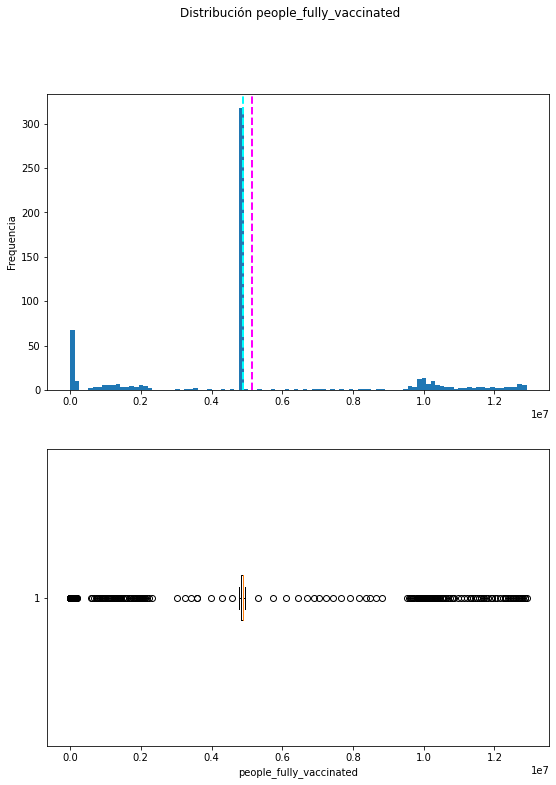

In [105]:
# Get the label column
label = df_selected['people_fully_vaccinated']

# Create a figure for 2 subplots (2 rows, 1 column)
fig, ax = plt.subplots(2, 1, figsize = (9,12))

# Plot the histogram   
ax[0].hist(label, bins=100)
ax[0].set_ylabel('Frequencia')

# Add lines for the mean, median, and mode
ax[0].axvline(label.mean(), color='magenta', linestyle='dashed', linewidth=2)
ax[0].axvline(label.median(), color='cyan', linestyle='dashed', linewidth=2)

# Plot the boxplot   
ax[1].boxplot(label, vert=False)
ax[1].set_xlabel('people_fully_vaccinated')

# Add a title to the Figure
fig.suptitle('Distribución people_fully_vaccinated')

# Show the figure
fig.show()

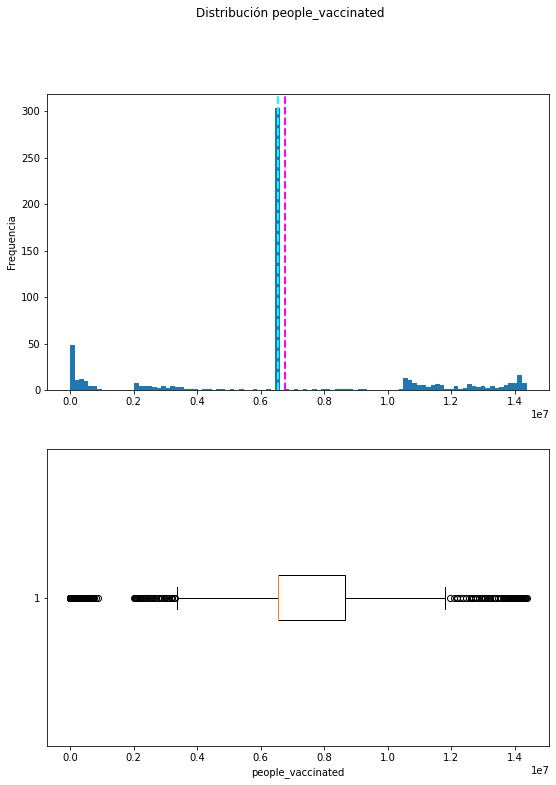

In [106]:
# Get the label column
label = df_selected['people_vaccinated']

# Create a figure for 2 subplots (2 rows, 1 column)
fig, ax = plt.subplots(2, 1, figsize = (9,12))

# Plot the histogram   
ax[0].hist(label, bins=100)
ax[0].set_ylabel('Frequencia')

# Add lines for the mean, median, and mode
ax[0].axvline(label.mean(), color='magenta', linestyle='dashed', linewidth=2)
ax[0].axvline(label.median(), color='cyan', linestyle='dashed', linewidth=2)

# Plot the boxplot   
ax[1].boxplot(label, vert=False)
ax[1].set_xlabel('people_vaccinated')

# Add a title to the Figure
fig.suptitle('Distribución people_vaccinated')

# Show the figure
fig.show()

## Entrenamiento del modelo
1. Separar las características y la variable a predecir.
2. Dividar los datos 70% para entrenamiento y 30% para prueba.

In [107]:
## Separar las características y la variable a predecir. 
X,y =  df_selected[['new_deaths_smoothed','new_tests_smoothed','positive_rate','people_fully_vaccinated', 'people_vaccinated']].values, df_selected['new_cases_smoothed'].values

In [108]:
## Dividir la data 70% para entrenamiento y 30% para prueba.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 424 rows
Test Set: 183 rows


Lasso() 

Coeficientes: [ 6.16356834e+00  1.58757859e-01  2.81508102e+03  1.10958748e-05
 -1.29797194e-05]
Intercepto: -462.25526268685496
Número de iteraciones:  156
alpha:  1.0
l1_ratio:  1.0
MSE: 75642.79173427534
RMSE: 275.0323467053927
R2: 0.6824480034300919


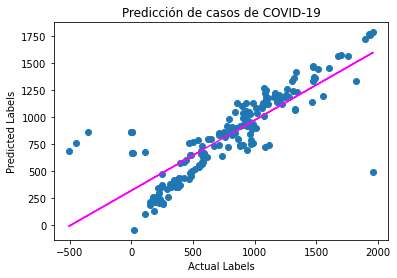

In [114]:
# Se establece el modelo Lasso para el conjunto de datos
model = Lasso().fit(X_train, y_train)
print (model, "\n")
print ('Coeficientes:', model.coef_)
print ('Intercepto:', model.intercept_)
print ('Número de iteraciones: ', model.n_iter_)
print ('alpha: ', model.alpha)
print ('l1_ratio: ', model.l1_ratio)

# Evaluate the model using the test data
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Predicción de casos de COVID-19')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

## Usando el modelo entrenado

In [110]:
import joblib

# Save the model as a pickle file
filename = './prediction-COVID.pkl'
joblib.dump(model, filename)

['./prediction-COVID.pkl']

In [111]:
# Load the model from the file
loaded_model = joblib.load(filename)

# Create a numpy array containing a new observation (por ejemplo, datos del día de mañana)
X_new = np.array([[9.571,	2995.0,	0.2508,	4.622973e+06,	6.278614e+06]]).astype('float64')
print ('New sample: {}'.format(list(X_new[0])))

# Use the model to predict tomorrow's rentals
result = loaded_model.predict(X_new)
print('Predicción: {:.0f} casos'.format(np.round(result[0])))

New sample: [9.571, 2995.0, 0.2508, 4622973.0, 6278614.0]
Predicción: 748 casos


In [112]:
X_new = np.array([[14.571,	3330.0,	0.2470,	4.622973e+06,	6.278614e+06]]).astype('float64')
print ('New sample: {}'.format(list(X_new[0])))

# Use the model to predict tomorrow's rentals
result = loaded_model.predict(X_new)
print('Predicción: {:.0f} casos'.format(np.round(result[0])))

New sample: [14.571, 3330.0, 0.247, 4622973.0, 6278614.0]
Predicción: 821 casos


In [113]:
X_new = np.array([[5.714,	4473.0,	0.2969,	1.269047e+07,	1.422460e+07]]).astype('float64')
print ('New sample: {}'.format(list(X_new[0])))

# Use the model to predict tomorrow's rentals
result = loaded_model.predict(X_new)
print('Predicción: {:.0f} casos'.format(np.round(result[0])))

New sample: [5.714, 4473.0, 0.2969, 12690470.0, 14224600.0]
Predicción: 1075 casos
